C:\Users\siris\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[5.44503195e-03 3.65356593e-04 2.49340386e-04 4.98119443e-04
 2.12966926e-04 3.37751622e-04 5.95538715e-03 5.26095799e-02
 9.45705878e-03 2.98965891e-04 1.77227855e-02 2.68204865e-03
 1.98316525e-03 1.12888895e-02 8.08338694e-05 7.12209999e-05
 8.53990567e-05 9.50841476e-03 1.04503171e-04 2.53461015e-04
 1.43562545e-02 2.17182758e-04 6.30654559e-04 2.25212169e-03
 7.06257108e-03 3.27719232e-02 3.87972898e-05 2.36068182e-05
 2.51472808e-03 5.15822342e-02 5.02224129e-04 4.42645398e-03
 2.78260459e-04 4.01932632e-03 1.94639641e-04 5.97294770e-06
 5.53675644e-05 1.51337610e-04 3.66917942e-03 3.47527989e-03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.08592900e-05
 2.78349766e-06 0.00000000e+00 3.66875435e-03 0.00000000e+00
 0.00000000e+00 2.18234977e-06 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

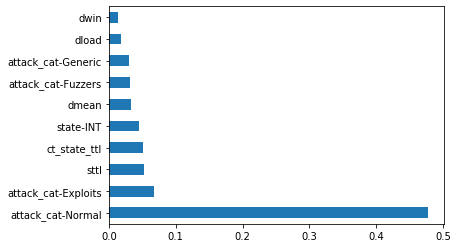

In [2]:
%matplotlib inline
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd



# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()



# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    
    
    
    
    
    


from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers


preprocess = True



filename_read = os.path.join(r"C:\Users\siris\OneDrive\Desktop\datasets\PROJECT1\combined_csv.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])


# create feature vector
encode_text_dummy(df, 'proto')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'state')
encode_text_dummy(df, 'attack_cat')
encode_text_index(df, 'label')
 

if preprocess:
    encode_numeric_zscore(df, 'dur')
    encode_numeric_zscore(df, 'spkts')
    encode_numeric_zscore(df, 'dpkts')
    encode_numeric_zscore(df, 'sbytes')
    encode_numeric_zscore(df, 'dbytes')
    encode_numeric_zscore(df, 'rate')
    encode_numeric_zscore(df, 'sttl')
    encode_numeric_zscore(df, 'dttl')
    encode_numeric_zscore(df, 'sload')
    encode_numeric_zscore(df, 'dload')
    encode_numeric_zscore(df, 'sloss')
    encode_numeric_zscore(df, 'dloss')
    encode_numeric_zscore(df, 'sinpkt')
    encode_numeric_zscore(df, 'dinpkt')
    encode_numeric_zscore(df, 'sjit')
    encode_numeric_zscore(df, 'djit')
    encode_numeric_zscore(df, 'swin')
    encode_numeric_zscore(df, 'stcpb')
    encode_numeric_zscore(df, 'dtcpb')
    encode_numeric_zscore(df, 'dwin')
    encode_numeric_zscore(df, 'tcprtt')
    encode_numeric_zscore(df, 'ackdat')
    encode_numeric_zscore(df, 'smean')
    encode_numeric_zscore(df, 'dmean')
    encode_numeric_zscore(df, 'trans_depth')
    encode_numeric_zscore(df, 'response_body_len')
    encode_numeric_zscore(df, 'ct_srv_src')
    encode_numeric_zscore(df, 'ct_state_ttl')
    encode_numeric_zscore(df, 'ct_dst_ltm')
    encode_numeric_zscore(df, 'ct_src_dport_ltm')
    encode_numeric_zscore(df, 'ct_dst_sport_ltm')
    encode_numeric_zscore(df, 'is_ftp_login')
    encode_numeric_zscore(df, 'ct_ftp_cmd')
    encode_numeric_zscore(df, 'ct_flw_http_mthd')
    encode_numeric_zscore(df, 'ct_src_ltm')
    encode_numeric_zscore(df, 'ct_srv_dst')
    encode_numeric_zscore(df, 'is_sm_ips_ports')
    


a = df.loc[:, df.columns != 'label']  #independent columns
b = df.label    #target column i.e price range
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(a,b)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=a.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()
c =feat_importances.nlargest(10)
c

l,y = to_xy(df,'label')
x=df[[ 'attack_cat-Normal',
'sttl',
'ct_state_ttl',
'id',
'state-FIN',
'dttl',
'attack_cat-Fuzzers',
'attack_cat-Exploits',
'attack_cat-Generic',   
'state-CON' ]]

x_train, x_test, y_train, y_test = train_test_split(x , y , test_size=0.3195179336, random_state=42)



In [3]:
checkpointer = ModelCheckpoint(filepath=r"C:\Users\siris\OneDrive\Desktop\datasets\PROJECT1A\best_weights.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    print(i)
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
     # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
print('Training finished...Loading the best model')  
print()
model.load_weights(r"C:\Users\siris\OneDrive\Desktop\datasets\PROJECT1A\best_weights.hdf5") # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)


pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
print(pred)


y_true= np.argmax(y_test,axis=1) 

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))


score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))


score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))


0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 175341 samples, validate on 82332 samples
Epoch 1/1000
175341/175341 - 13s - loss: 48.2541 - val_loss: 4.2236
Epoch 2/1000
175341/175341 - 8s - loss: 38.3293 - val_loss: 50.1909
Epoch 3/1000
175341/175341 - 9s - loss: 29.5829 - val_loss: 52.5033
Epoch 4/1000
175341/175341 - 8s - loss: 32.8807 - val_loss: 84.8967
Epoch 5/1000
175341/175341 - 7s - loss: 25.9726 - val_loss: 16.5497
Epoch 6/1000
175341/175341 - 7s - loss: 25.2704 - val_loss: 3.8999
Epoch 7/1000
175341/175341 - 7s - loss: 21.0811 - val_loss: 2.2334
Epoch 8/1000
175341/175341 - 8s - loss: 18.2236 - val_loss: 3.6736
Epoch 9/1000
175341/175341 - 8s - loss: 14.8798 - val_loss: 75.0584
Epoch 10/1000
175341/175341 - 6s - loss: 17.5152 - val_loss: 15.6339
Epoch 11/1000
175341/175341 - 6s - loss: 15.1869 - val_loss: 9.4370
Epoch 12/1000
175341/175341 - 6s - loss: 13.6733 - val_loss: 14.2483
Epoch 00012: early stopping
1
Train on 175341 sampl

[[29755     0]
 [  531 52046]]
Plotting confusion matrix


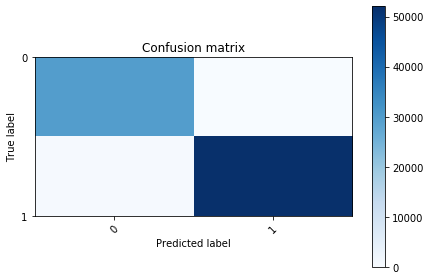

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     29755
           1       1.00      0.99      0.99     52577

    accuracy                           0.99     82332
   macro avg       0.99      0.99      0.99     82332
weighted avg       0.99      0.99      0.99     82332



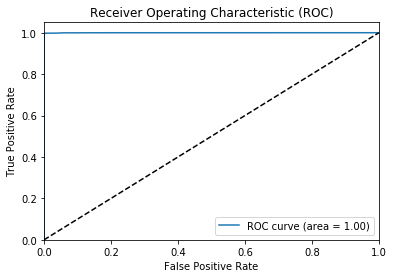

In [4]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

lab = encode_text_index(df, 'label')
plt.figure()
plot_confusion_matrix(cm, lab)
plt.show()


print(classification_report(y_true, pred))


pred = model.predict(x_test)
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)